# Model Behavior
Apply logistic regression. Predict memory recall given alpha, gamma, and exponent changes on a single trial basis.

## Set-up

In [1]:
# Imports - standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import ttest_1samp, zscore, linregress
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import accuracy_score


### Imports

In [2]:
# Imports - custom
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from info import PATIENTS
from settings import COLORS

### Settings

In [3]:
# set plotting style
plt.style.use("../mplstyle/default.mplstyle")

### Functions

In [4]:
# Ordinal logistic regression helper func

def run_ordered_logit(results, features_x, feature_y):
    """
    Run ordered logistic regression to predict behavior (confidence rating)
    from spectral parameters, for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.    

    Returns
    -------
    clf : sklearn LogisticRegression object
        Logistic regression classifier.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x]
    y = results[feature_y]

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    for feature in features_x:
        X[feature] = zscore(X[feature])

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # run ordered logistic regression
    model = OrderedModel(y_train, X_train, distr='logit')
    results = model.fit(method='bfgs')

    # predict
    pred_probs = results.predict(X_test)
    pred_categories = np.argmax(pred_probs.values, axis=1) + 1
    score = accuracy_score(y_test, pred_categories)

    return model, results, score



In [5]:
# Binary Logistic regression helper func

def run_logistic_regression(results, features_x, feature_y):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.    

    Returns
    -------
    model : statsmodels Logit object
        Logistic regression model.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x]
    y = results[feature_y]

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # z-score each feature
    for feature in features_x:
        X[feature] = zscore(X[feature])

    # run logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = sm.Logit(y_train, X_train).fit()
    y_pred_prob = model.predict(X_test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    score = accuracy_score(y_test, y_pred).astype(float)

    return model, score
    

In [6]:
# Binary Logistic regression with cross-validation helper func

def run_logistic_regression_cv(results, features_x, feature_y):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material, using cross-validation.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.  

    Returns
    -------
    clf : sklearn LogisticRegression object
        Logistic regression classifier.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x].to_numpy()
    y = results[feature_y].to_numpy()

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    X = zscore(X, axis=0)

    # run logistic regression with cross-validation
    clf = LogisticRegression(random_state=0)
    scores = cross_val_score(clf, X, y, cv=5)
    score = scores.mean()

    return clf, score



In [7]:
# plotting functions

def plot_score(df, chance=0.5):
    # plot scores by material
    _, ax = plt.subplots(figsize=[6,4])
    bin_edges = np.arange(0, 1.1, 0.1)
    ax.hist(df.loc[df['material']=='words', 'score'], bin_edges, alpha=0.5, label='word-encoding')
    ax.hist(df.loc[df['material']=='faces', 'score'], bin_edges, alpha=0.5, label='face-encoding')
    # ax.axvline(0.5, color='k', linestyle='--')
    ax.axvline(chance, color='k', linestyle='--')
    ax.set(xlabel='score', ylabel='count')
    ax.set_title("logistic regression scores")
    ax.legend()
    plt.show()

    # plot scores by patient and material
    _, ax = plt.subplots(1, 2, figsize=[12, 4])
    for ax, material in zip(ax, ['words', 'faces']):
        for i_patient, patient in enumerate(PATIENTS):
            ax.hist(df.loc[(df['patient']==patient) & (df['material']==material), 'score'], bin_edges, alpha=0.5, color=f'C{i_patient}')
            ax.axvline(df.loc[(df['patient']==patient) & (df['material']==material), 'score'].mean(), color=f'C{i_patient}', linestyle='--')
        ax.set(xlabel='score', ylabel='count', title=material)
        ax.axvline(chance, color='k', linestyle='--')
    plt.show()

    # print mean scores
    print(f"mean score:\t\t {df['score'].mean():0.3f}")
    print(f"\nmean word score:\t {df.loc[df['material']=='words', 'score'].mean():0.3f}")
    print(f"median word score:\t {df.loc[df['material']=='words', 'score'].median():0.3f}")
    print(f"\nmean face score:\t {df.loc[df['material']=='faces', 'score'].mean():0.3f}")
    print(f"median face score:\t {df.loc[df['material']=='faces', 'score'].median():0.3f}")


## Main

### load data
* load single-trial spectral parameterization results
* load behavioral metadata
* merge

In [ ]:
# load single trial spectral parameter results (pipeline step 7)
df = pd.read_csv(f"{PROJECT_PATH}/data/results/psd_trial_params.csv")
df = df.pivot_table(index=["patient", "material", "memory", "chan_idx", "trial"], columns="epoch", values=["exponent", "alpha", "alpha_adj", "gamma", "gamma_adj"])
for feature in ["exponent", "alpha", "alpha_adj", "gamma", "gamma_adj"]:
    df[(feature, "diff")] = df[(feature, 'post')] - df[(feature, 'pre')]
    df.drop(columns=[(feature, 'pre'), (feature, 'post')], inplace=True)
df.columns = [f"{feature}_{epoch}" for feature, epoch in df.columns]
df.reset_index(inplace=True)
df.rename(columns={"chan_idx": "channel"}, inplace=True)
results = df.copy()
results


In [ ]:
# # load single trial spectral parameter results (pipeline step 7)
# results = pd.read_csv(f"{PROJECT_PATH}/data/results/single_trial_params.csv", index_col=0)
# results

In [ ]:
# aggregate metadata for all patients (including behavioral data)

# from paths import DATASET_PATH
# sys.path.append("../scripts/pipeline")
# from step1_convert_matlab_to_python import import_epochs

# metadata = []

# dir_input = f"{DATASET_PATH}/iEEG"
# for patient in PATIENTS:
#     for material in ['words', 'faces']:
#         fname = f"{patient}_{material}.mat"
        
#         # display progress
#         print('\n__________Reformatting: %s ____________________\n' %fname)
    
#         # import epoch data
#         epochs = import_epochs(f"{dir_input}/{fname}")

#         metadata_i = epochs.metadata.reset_index()
#         metadata_i.rename(columns={'index' : 'trial'}, inplace=True)
#         f_parts = fname.split('_')
#         metadata_i['patient'] = patient
#         metadata_i['material'] = material
#         metadata.append(metadata_i)

# # combine and save to file
# metadata = pd.concat(metadata).reset_index(drop=True)
# metadata.to_csv(f"{PROJECT_PATH}/data/ieeg_metadata/metadata.csv", index=False)

# load
metadata = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/metadata.csv")
metadata

In [ ]:
# # count the number of times each 'patient' had each 'confidence' rating
# confidence_counts = metadata.groupby(['patient', 'confidence']).size().unstack()
# confidence_counts = confidence_counts.fillna(0)
# confidence_counts = confidence_counts.astype(int).reset_index()
# # confidence_counts = confidence_counts.div(confidence_counts.sum(axis=1), axis=0) * 100 # change to percentage

# # plot the number of times each 'patient' had each 'confidence' rating
# _, ax = plt.subplots(figsize=[8,6])
# sns.heatmap(confidence_counts.set_index('patient'), cmap='hot', ax=ax)
# ax.set_title("confidence ratings")
# plt.show()



In [ ]:
# merge results and metadata
# results['material'] = results['material'] + 's'
results = results.merge(metadata, on=['patient', 'material', 'trial'])
results

### Run regression
Regress behavior on spectral features
* Ordered/ordinal logistic regression (1-6 confidence rating)
* Binary logistic regression (binary remembered/forgotten)
* Binary logistic regression with cross-validation

#### Ordered logistic regression
regress behavior (confidence rating, 1-6) on spectral parameters 

In [ ]:
# # run ordered logistic regression for all channels in each trial condition

# features_x = ['exp_diff', 'alpha_diff', 'gamma_diff']

# # create dataframe to store results (one row for each channel-material pair)
# df = pd.DataFrame(columns=['patient', 'material', 'channel', 'exp_coef', 
#                            'alpha_coef', 'gamma_coef', 'exp_pval',
#                             'alpha_pval', 'gamma_pval', 'score'])

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'channel'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data 
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['channel']==channel) & \
#                                     (results['material']==material)]
#                 model, res, score = run_ordered_logit(res_i, features_x, 'confidence')
#                 df_i = pd.DataFrame({'patient' : patient,
#                                     'material' : material,
#                                     'channel' : channel,
#                                     'exp_coef' : res.params[0],
#                                     'alpha_coef' : res.params[1],
#                                     'gamma_coef' : res.params[2],
#                                     'exp_pval' : res.pvalues[0],
#                                     'alpha_pval' : res.pvalues[1],
#                                     'gamma_pval' : res.pvalues[2],
#                                     'score' : score},
#                                     index=[0])
#                 df = pd.concat([df, df_i], axis=0)
#             except:
#                 pass

# df

In [ ]:
# save/load results from above
# df.to_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)
df

#### Logistic regression (binary)
regress behavior (binarized memory performance) on spectral parameters

In [ ]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exp_diff', 'alpha_diff', 'gamma_diff']

# # create dataframe to store results (one row for each channel-material pair)
# df = pd.DataFrame(columns=['patient', 'material', 'channel', 'exp_coef', 
#                            'alpha_coef', 'gamma_coef', 'score'])

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     channels = results.loc[results['patient']==patient, 'channel'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data 
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['channel']==channel) & \
#                                     (results['material']==material)]
#                 model, score = run_logistic_regression(res_i, features_x, 'behavior')
#                 df_i = pd.DataFrame({'patient' : patient,
#                                     'material' : material,
#                                     'channel' : channel,
#                                     'exp_coef' : model.params[1],
#                                     'alpha_coef' : model.params[2],
#                                     'gamma_coef' : model.params[3],
#                                     'exp_pval' : model.pvalues[1],
#                                     'alpha_pval' : model.pvalues[2],
#                                     'gamma_pval' : model.pvalues[3],
#                                     'score' : score},
#                                     index=[0])
#                 df = pd.concat([df, df_i], axis=0)
#             except:
#                 pass

# df

In [ ]:
# save/load results from above
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
df

#### Logistic regression (binary) with cross-validation
regress behavior (binarized memory performance) on spectral parameters

In [ ]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exponent_diff', 'alpha_diff', 'gamma_diff']
# feature_y = 'recalled'

# # create dataframe to store results (one row for each channel-material pair)
# df = results.groupby(['patient', 'channel', 'material']).mean().reset_index()
# df = df[['patient', 'channel', 'material']]
# df['score'] = np.nan 

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     channels = results.loc[results['patient']==patient, 'channel'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['channel']==channel) & \
#                                     (results['material']==material)]
#                 clf, score = run_logistic_regression_cv(res_i, features_x, 
#                                                         feature_y)
#                 df_index = (df['patient']==patient) & (df['channel']==channel) & (df['material']==material)
#                 df.loc[df_index, 'score'] = score
#             except:
#                 pass

# df

In [ ]:
# save/load results
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
df

### Plot regression results

In [ ]:
# set chance level (0.5 for binary classification, 1/6 for 6-class classification)
chance = 0.5

In [ ]:
# convert score to float
df['score'] = df['score'].astype(float)

In [ ]:
# plot score and print average scores
plot_score(df, chance=chance)

In [ ]:
# plot histogram of coefficients

# get those with scores above chance
df_plt = df.loc[df['score']>(0.7)]
# df_plt = df.copy()

# plot
all_values = df_plt[['exponent_coef', 'alpha_coef', 'gamma_coef']].values.flatten()
bins = np.linspace(np.min(all_values), np.max(all_values), 30)
_, ax = plt.subplots(1, 3, figsize=[12, 4], sharey=True, constrained_layout=True)
for i, feature in enumerate(['exp_coef', 'alpha_coef', 'gamma_coef']):
    ax[i].hist(df_plt[feature], bins, color=COLORS['blue'])
    ax[i].set(xlabel=feature, ylabel='count')
    ax[i].axvline(0, color='k', linestyle='--') 
plt.show()


# plot
all_values = df_plt[['exponent_coef', 'alpha_coef', 'gamma_coef']].values.flatten()
bins = np.linspace(np.min(all_values), np.max(all_values), 30)
_, ax = plt.subplots(figsize=[6, 4])
for i, feature in enumerate(['exp_coef', 'alpha_coef', 'gamma_coef']):
    ax.hist(df_plt[feature], bins, alpha=0.5, label=feature)
ax.axvline(0, color='k', linestyle='--')
ax.set(xlabel='coefficient', ylabel='count')
ax.legend()
plt.show()


In [ ]:
# plot histogram of pvalues

# get those with scores above chance
# df_plt = df.loc[df['score']>(1/6)]
df_plt = df.copy()

# plot
_, ax = plt.subplots(1, 3, figsize=[12, 4], sharey=True, constrained_layout=True)
for i, feature in enumerate(['exp_pval', 'alpha_pval', 'gamma_pval']):
    ax[i].hist(df_plt[feature])
    ax[i].set(xlabel=feature, ylabel='count')
plt.show()


### Analyze coefficients and p-values
Run stats and create figures for manuscript

In [ ]:
# run 1-smaple t-test to determine if coefficients are significantly different from 0

# print coefficients
print(f"Mean coefficients:")
print(f"exp:\t {df['exp_coef'].mean():0.5f}")
print(f"alpha:\t {df['alpha_coef'].mean():0.5f}")
print(f"gamma:\t {df['gamma_coef'].mean():0.5f}")

# run 1 sample t-test
print("\n\nT-test results:")
for ii in range(3):
    data_i = df.iloc[:,ii+3].to_numpy()
    t, p = ttest_1samp(data_i, 0)
    print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")
    
# run 1 sample t-test for word-/face-encoding only
for material in ['words', 'faces']:
    print(f"\n\nT-test, {material}-encoding:")
    df_m = df.loc[df['material']==material] # subset dataframe
    for ii in range(3):
        data_i = df_m.iloc[:,ii+3]
        t, p = ttest_1samp(data_i, 0)
        print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")

In [ ]:
# analyze coefficients for predictive channels only

def analyze_coef(df):
    """
    Evaluate whether logistic regression coefficients are significantly different
    than zero. Print results of 1-sample t-test.
    """

    for material in ['words', 'faces']:
        print(f"\nT-test, {material}-encoding:")
        for ii in range(3):
            df_m = df.loc[df['material']==material]
            data_i = df_m.iloc[:,ii+3]
            t, p = ttest_1samp(data_i, 0)
            print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.5f}, p={p:0.5f}")

# test 
for threshold in np.linspace(0.1,0.9,9):
    print(f"\n\nThreshold = {threshold} ********************")
    df_i = df.loc[df['score'] > threshold]
    analyze_coef(df_i)

In [ ]:
# count number of signifcant coefficients for each feature
alpha = 0.05
for feature in ['exp', 'alpha', 'gamma']:
    n_sig = np.sum(df[f'{feature}_pval']<alpha)
    print(f"{feature}:\t{n_sig} ({n_sig/len(df)*100:0.2f}%)")


These results suggest that modulation of the aperiodic exponent on a single-trial basis is predictive of memory recall for word-encoding trials but not for face-eencoding trials. 

In [ ]:
# plot violin plot of regression scores

# set plotting params
plotting_params = {
    'data'  :   df,
    'x'     :   'material',
    'y'     :   'score',
}

# plot
_, ax = plt.subplots(figsize=[4,3])
sns.violinplot(**plotting_params, ax=ax, color=COLORS['blue'])
ax.axhline(chance, color='k', linestyle='--')

# add significance markers
for i_material, material in enumerate(['words', 'faces']):
# for i_material, material in enumerate(['words', 'faces']):
    data = df.loc[df['material']==material, 'score']
    data = data[~np.isnan(data)]
    t, p = ttest_1samp(data, chance)
    if p < 0.05:
        ax.text(i_material, np.max(df['score'])*1.15, '*', fontsize=12, ha='center', va='center')

    # print stats
    print(f"\nT-test, {material}-encoding:")
    print(f"t={t:0.3f}, p={p:0.3n}")

ax.set_ylim([np.min(df['score'])-np.min(df['score'])*0.3, np.max(df['score'])*1.3])
ax.set(ylabel='regression score')
plt.show()

#### plot score v. electrode coordinate

In [ ]:
# load regression results from above
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)

# merge channel info with regression results
df = pd.merge(results, df_elec, on=['patient', 'channel'])
df

In [ ]:
# compute correlation between score and position

# drop NaN
df_c = df.dropna()
x_data = df_c['pos_y']
y_data = df_c['score']

# plot data
fig, ax = plt.subplots(figsize=[4,3])
ax.scatter(x_data, y_data, c=y_data, cmap='viridis')
ax.set(xlabel=f"AP coordinate", ylabel="regression score")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax.plot(t_lin, lin, color='k', linewidth=2)
ax.text(0.05, 0.75, f"r={stats.rvalue:0.3f}\np={stats.pvalue:0.1e}",
        transform=ax.transAxes, backgroundcolor='w', fontsize=12)

plt.show()

In [ ]:
# compute correlation between coeeficient and position

# load regression results (with coefficients - not cross-validated)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)
df_plt = pd.merge(results, df_elec, on=['patient', 'channel'])

# get those with scores above chance
df_plt = df_plt.loc[df_plt['score']>(0.5)]

# drop NaN
df_c = df_plt.dropna()
x_data = df_c['pos_y']

# create fig
fig, axes = plt.subplots(1, 3, figsize=[7.5, 3], constrained_layout=True)
titles = ['exponent', 'adjusted alpha', 'adjusted gamma']
for ax, feature, title in zip(axes, ['exp', 'alpha', 'gamma'], titles):
        y_data = df_c[f'{feature}_coef']

        # plot data
        ax.set_title(title)
        ax.scatter(x_data, y_data, color=COLORS['blue'], alpha=0.5)
        ax.set(xlabel=f"AP coordinate", ylabel="regression coefficient")

        # run regression and plot results
        stats = linregress(x_data, y_data)
        t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
        lin = stats.slope * t_lin + stats.intercept
        ax.plot(t_lin, lin, color='k', linewidth=3)
        if stats.pvalue > 0.01:
                ax.text(0.05, 0.84, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.3n}", 
                        transform=ax.transAxes, backgroundcolor='w', fontsize=12)
        else:
                ax.text(0.05, 0.84, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}", 
                        transform=ax.transAxes, backgroundcolor='w', fontsize=12)

plt.show()

#### combine figures for manuscript

In [ ]:
# manuscript figure

# init
fig, (ax_b, ax_c, ax_d) = plt.subplots(1, 3, figsize=[6, 2], constrained_layout=True)


# B. plot violin plot of regression scores =====================================
# set plotting params
plotting_params = {
    'data'  :   df,
    'x'     :   'material',
    'y'     :   'score',
}

# plot
sns.violinplot(**plotting_params, ax=ax_b, color=COLORS['blue'])
ax_b.axhline(chance, color='k', linestyle='--')
ax_b.set_ylim([np.min(df['score'])-np.min(df['score'])*0.3, np.max(df['score'])*1.3])
ax_b.set(ylabel='regression score')

# add significance markers
for i_material, material in enumerate(['words', 'faces']):
    data = df.loc[df['material']==material, 'score']
    data = data[~np.isnan(data)]
    t, p = ttest_1samp(data, chance)
    if p < 0.05:
        ax_b.text(i_material, np.max(df['score'])*1.15, '*', fontsize=12, ha='center', va='center')

# C. scatter plot: correlate regresion score and AP coordinate =================

# drop NaN
df_c = df.dropna()
x_data = df_c['pos_y']
y_data = df_c['score']

# plot data
ax_c.scatter(x_data, y_data, c=y_data, cmap='viridis')
ax_c.set(xlabel=f"AP coordinate", ylabel="regression score")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_c.plot(t_lin, lin, color='k', linewidth=2)
ax_c.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}",
        transform=ax_c.transAxes, backgroundcolor='w')


# D. scatter plot: correlate exponent coeeficient and AP coordinate ============
# load regression results (with coefficients - not cross-validated)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)
df_plt = pd.merge(results, df_elec, on=['patient', 'channel'])

# drop NaN
df_c = df_plt.dropna()
x_data = df_c['pos_y']
y_data = df_c['exp_coef']

# plot data
ax_d.scatter(x_data, y_data, color=COLORS['blue'], alpha=0.5)
ax_d.set(xlabel=f"AP coordinate", ylabel="exponent coefficient")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax_d.plot(t_lin, lin, color='k', linewidth=3)
if stats.pvalue > 0.01:
        ax_d.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.3n}", 
                transform=ax_d.transAxes, backgroundcolor='w')
else:
        ax_d.text(0.05, 0.8, f"r = {stats.rvalue:0.3f}\np = {stats.pvalue:0.1e}", 
                transform=ax_d.transAxes, backgroundcolor='w')


# save fig
plt.savefig(f"{PROJECT_PATH}/figures/main_figures/model_behavior_bcd.png")


Scores follow cognitive hierarchy, with more frontal channels better predicticting memory behavior

### Plot topography of regression results - PyVista

switch to pyvista environment

#### imports

In [ ]:
# imports

# general
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# local
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from plots import plot_data_spatial
from settings import COLORS

In [ ]:
# auto reload
%load_ext autoreload
%autoreload 2

#### load data

In [ ]:
# load regression results from above
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)

# merge channel info with regression results
df = pd.merge(results, df_elec, on=['patient', 'channel'])

df

### plot topography

In [ ]:
# plot topo map of scores

# loop through materials
for material in ['word', 'face']:

    # get info for trial block 
    df_i = df.loc[df['material']==material]
    df_i = df_i.dropna()
    elec_pos = df_i[['pos_x', 'pos_y', 'pos_z']]

    # split data by hemisphere
    pos = dict()
    score = dict()
    pos['right'] = elec_pos[elec_pos['pos_x'] >= 0].to_numpy()
    score['right'] = df_i.loc[df_i['pos_x'] >= 0, 'score'].to_numpy()
    pos['left'] = elec_pos[elec_pos['pos_x'] < 0].to_numpy()
    score['left'] = df_i.loc[df_i['pos_x'] < 0, 'score'].to_numpy()

    # plot ech hemisphere 
    for hemi in ['right', 'left']:
        for view in ['lateral', 'medial']:
            plot_data_spatial(score[hemi], pos[hemi], hemi, view,
                    cbar_label='regression score')

In [ ]:
# prep data for plotting mean score across materials

# pivot score on material
index =['patient', 'channel', 'pos_x', 'pos_y', 'pos_z']
df_p = df.pivot(index=index, columns='material', values='score')

# compute mean score across materials
df_p['score'] = df_p.mean(axis=1)
df_p.reset_index(inplace=True)
df_p

In [ ]:
# plot mean score across materials

# set output path
path_out = f"{PROJECT_PATH}/figures/behavioral_modeling"
if not os.path.exists(f"{path_out}/temp"):
    os.makedirs(f"{path_out}/temp")

# get info for trial block 
df_i = df_p.dropna()
elec_pos = df_i[['pos_x', 'pos_y', 'pos_z']]

# split data by hemisphere
pos = dict()
score = dict()
pos['right'] = elec_pos[elec_pos['pos_x'] >= 0].to_numpy()
score['right'] = df_i.loc[df_i['pos_x'] >= 0, 'score'].to_numpy()
pos['left'] = elec_pos[elec_pos['pos_x'] < 0].to_numpy()
score['left'] = df_i.loc[df_i['pos_x'] < 0, 'score'].to_numpy()

# plot each hemisphere/view
clim = [np.min(df_p['score']), np.max(df_p['score'])]
for hemi in ['right', 'left']:
    for view in ['lateral', 'medial']:
        fname_out = f"{path_out}/temp/behavioral_modeling_{hemi}_{view}.png"
        plot_data_spatial(score[hemi], pos[hemi], hemi, view, plot_cbar=False,
                          fname_out=fname_out, elec_size=36, clim=clim)
        
# combine hemispheres and views into a single figure and save to file
images = [plt.imread(f"{path_out}/temp/{f}") for f in os.listdir(f"{path_out}/temp")]
image = np.concatenate(images, axis=1)
fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.imshow(image)
ax.axis('off')
fig.savefig(f"{path_out}/behavioral_modeling.png", bbox_inches='tight')

In [ ]:
# plot an example of the plot above to screenshot the colorbar
plot_data_spatial(score[hemi], pos[hemi], hemi, view, clim=clim)

### Sensitivity analysis

In [8]:
# identify/create output path
path_out = f"{PROJECT_PATH}/figures/behavioral_modeling"
if not os.path.exists(path_out):
    os.makedirs(path_out)

In [9]:
# load all scores
dir_input = f"{PROJECT_PATH}/data/specparam_sensitivity_analysis/logit_scores"
files = os.listdir(dir_input)

df_list = []
for fname in files:
    idx = fname.split('_')[-1].split('.')[0]
    df_i = pd.read_csv(f"{dir_input}/{fname}", index_col=0)
    df_i.insert(0, 'idx', idx)
    df_list.append(df_i)

df_score = pd.concat(df_list)
df_score

,idx,patient,channel,material,ap_mode,score
0,0,pat02,0,faces,fixed,0.581667
1,0,pat02,0,faces,knee,0.583333
2,0,pat02,0,words,fixed,0.787500
3,0,pat02,0,words,knee,0.787500
4,0,pat02,1,faces,fixed,0.639706
...,...,...,...,...,...,...
2681,9,pat22,51,words,knee,0.501053
2682,9,pat22,52,faces,fixed,0.604575
2683,9,pat22,52,faces,knee,0.592810
2684,9,pat22,52,words,fixed,0.520000


In [10]:
# print indices present

print('Parameters present:')
print(df_score['idx'].unique())

print('\nParameter sets 10 and 11 failed to run. These included low peak thresholds (1 and 2 STDs)')


Parameters present:
['0' '1' '12' '13' '14' '2' '3' '4' '5' '6' '7' '8' '9']

Parameter sets 10 and 11 failed to run. These included low peak thresholds (1 and 2 STDs)


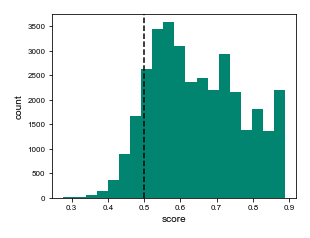

t = 223.382, p = 0.0e+00


In [11]:
# simply plot hist of all scores
_, ax = plt.subplots(figsize=[4,3])
ax.hist(df_score['score'], bins=20, color=COLORS['blue'])
ax.set(xlabel='score', ylabel='count')
ax.axvline(0.5, color='k', linestyle='--')
plt.show()

# one-sample t-test
scores = df_score.dropna()['score']
t, p = ttest_1samp(scores, 0.5)
print(f"t = {t:0.3f}, p = {p:1.1e}")


In [12]:
# load electrode locations and merge with scores

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)

# merge channel info with regression results
df = pd.merge(df_score, df_elec, on=['patient', 'channel'])
df

,idx,patient,channel,material,ap_mode,score,label,pos_y,pos_x,pos_z
0,0,pat02,0,faces,fixed,0.581667,A01-A02,-65.431,61.9449,3.55955
1,0,pat02,0,faces,knee,0.583333,A01-A02,-65.431,61.9449,3.55955
2,0,pat02,0,words,fixed,0.787500,A01-A02,-65.431,61.9449,3.55955
3,0,pat02,0,words,knee,0.787500,A01-A02,-65.431,61.9449,3.55955
4,1,pat02,0,faces,fixed,0.556667,A01-A02,-65.431,61.9449,3.55955
...,...,...,...,...,...,...,...,...,...,...
34913,8,pat22,52,words,knee,0.477895,MOF_09-MOF_10,52.000,-14.0000,30.00000
34914,9,pat22,52,faces,fixed,0.604575,MOF_09-MOF_10,52.000,-14.0000,30.00000
34915,9,pat22,52,faces,knee,0.592810,MOF_09-MOF_10,52.000,-14.0000,30.00000
34916,9,pat22,52,words,fixed,0.520000,MOF_09-MOF_10,52.000,-14.0000,30.00000


In [13]:
# define function to run and collect stats

def analyze_scores(df):
    """
    Perform stats:
        1. Run one-sample t-test: scores v. chance (for each block)
        2. Regress score on AP coordinate
    """

    # init
    df_c = df.dropna()
    results = np.zeros(4)

    # 1. one-sample t-test: scores v. chance
    t, p = ttest_1samp(df_c['score'], 0.5)
    results[0] = t
    results[1] = p

    # 2. regress score on AP coordinate
    regress = linregress(df_c['pos_y'], df_c['score'])
    results[2] = regress.rvalue
    results[3] = regress.pvalue
    
    return results


In [14]:
# run and collect stats

columns=['ttest_t', 'ttest_p', 'regress_r', 'regress_p']
stats_list = []

for material in ['words', 'faces']:
    for idx in df['idx'].unique():
        df_i = df.loc[(df['idx']==idx) & (df['material']==material)]
        stats_i = analyze_scores(df_i)
        stats_i = pd.DataFrame(stats_i, index=columns).T
        stats_i.insert(0, 'idx', idx)
        stats_i.insert(1, 'material', material)
        stats_list.append(stats_i)

df_stats = pd.concat(stats_list)
df_stats.head()


,idx,material,ttest_t,ttest_p,regress_r,regress_p
0,0,words,51.343928,2.549616e-318,0.282261,6.838983e-26
0,1,words,51.543816,8.100700e-320,0.280554,1.379293e-25
0,12,words,51.719787,3.893237e-321,0.283543,4.023756e-26
0,13,words,51.719226,3.942644e-321,0.278073,3.793133e-25
0,14,words,51.755195,2.114601e-321,0.278067,3.802313e-25


In [15]:
# # plot violin plot of ttest stats

# # ttest violin plot 
# fig, ax = plt.subplots(1, 3, figsize=[6.5, 2], constrained_layout=True)
# # fig.suptitle(f"Sensitivity analysis for t-test (score v. chance)")
# fig.suptitle(f"Sensitivity analysis for Fig 9B")

# sns.violinplot(data=df_stats, x='material', y='ttest_t', ax=ax[0], color=COLORS['blue'])
# ax[0].set(ylabel='t-statistic')

# # plot p-values materials separately (for better visualization)
# for i_material, material in enumerate(['words', 'faces']):
#     sns.violinplot(data=df_stats.loc[df_stats['material']==material], y='ttest_p', ax=ax[1+i_material], color=COLORS['blue'])
#     ax[1+i_material].set(xlabel=material, ylabel='p-value')
#     ax[1+i_material].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# # save/show
# plt.savefig(f"{path_out}/sensitivity_analysis_ttest.png")
# plt.show()


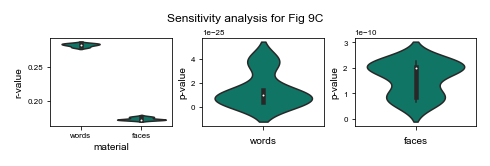

Mean t-statistics:
material
faces    0.174334
words    0.281431
Name: regress_r, dtype: float64

Mean p-values:
material
faces    1.591049e-10
words    1.427183e-25
Name: regress_p, dtype: float64


In [16]:
# plot violin plot of regression stats

# regression violin plot
fig, ax = plt.subplots(1, 3, figsize=[6.5, 2], constrained_layout=True)
# fig.suptitle(f"Sensitivity analysis for regression (score v. coordinate)")
fig.suptitle(f"Sensitivity analysis for Fig 9C")

sns.violinplot(data=df_stats, x='material', y='regress_r', ax=ax[0], color=COLORS['blue'])
ax[0].set(ylabel='r-value')

# plot p-values materials separately (for better visualization)
for i_material, material in enumerate(['words', 'faces']):
    sns.violinplot(data=df_stats.loc[df_stats['material']==material], y='regress_p', ax=ax[1+i_material], color=COLORS['blue'])
    ax[1+i_material].set(xlabel=material, ylabel='p-value')

# save/show
plt.savefig(f"{path_out}/sensitivity_analysis_regression.png")
plt.show()

# print means
print("Mean t-statistics:")
print(df_stats.groupby('material')['regress_r'].mean())
print("\nMean p-values:")
print(df_stats.groupby('material')['regress_p'].mean())



In [17]:
# run and collect stats - average within patient

# init
t_values = []
p_values = []
materials_ = []
ap_modes_ = []
indices_ = []

# average df over channels within each patient
df_p = df.groupby(['patient', 'material', 'ap_mode', 'idx']).mean().reset_index().drop(columns=['channel', 'pos_x', 'pos_y', 'pos_z'])

# run
for material in ['words', 'faces']:
    for idx in df_p['idx'].unique():
        for ap_mode in ['fixed', 'knee']:
            df_i = df_p.loc[(df_p['idx']==idx) & (df_p['material']==material) & (df_p['ap_mode']==ap_mode)]
            t, p = ttest_1samp(df_i['score'], 0.5)
            t_values.append(t)
            p_values.append(p)
            materials_.append(material)
            ap_modes_.append(ap_mode)
            indices_.append(idx)

# create df
df_stats_p = pd.DataFrame({'idx': indices_, 'material': materials_, 
                         'ap_mode': ap_modes_, 'ttest_t': t_values, 
                         'ttest_p': p_values})
df_stats_p.head()



,idx,material,ap_mode,ttest_t,ttest_p
0,0,words,fixed,5.515619,0.000133
1,0,words,knee,5.556981,0.000124
2,1,words,fixed,5.557256,0.000124
3,1,words,knee,5.557353,0.000124
4,12,words,fixed,5.611533,0.000114


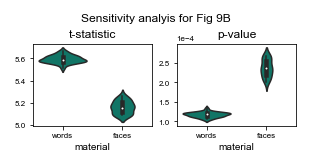

Mean t-statistics:
material
faces    5.162254
words    5.594883
Name: ttest_t, dtype: float64

Mean p-values:
material
faces    0.000237
words    0.000117
Name: ttest_p, dtype: float64


In [18]:
# plot violin plot of ttest stats

# ttest violin plot 
fig, ax = plt.subplots(1, 2, figsize=[4, 2], constrained_layout=True)
# fig.suptitle(f"Sensitivity analyis for t-test (score v. chance)")
fig.suptitle(f"Sensitivity analyis for Fig 9B")

sns.violinplot(data=df_stats_p, x='material', y='ttest_t', ax=ax[0], color=COLORS['blue'])
ax[0].set(ylabel='', title='t-statistic')

sns.violinplot(data=df_stats_p, x='material', y='ttest_p', ax=ax[1], color=COLORS['blue'])
ax[1].set(ylabel='', title='p-value')
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# save/show
plt.savefig(f"{path_out}/sensitivity_analysis_ttest.png")
# plt.savefig(f"{path_out}/figure_s2.png")
plt.show()

# print means
print("Mean t-statistics:")
print(df_stats_p.groupby('material')['ttest_t'].mean())
print("\nMean p-values:")
print(df_stats_p.groupby('material')['ttest_p'].mean())

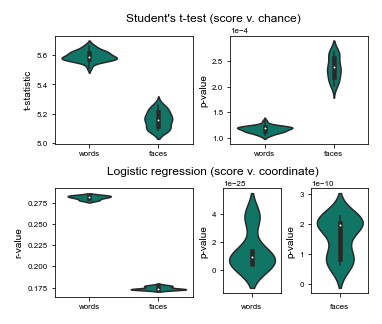

In [21]:
# create figure and gridspec
fig = plt.figure(figsize=[5, 4], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[1,1], height_ratios=[1,1])
ax_a = fig.add_subplot(spec[0,0])
ax_b = fig.add_subplot(spec[0,1])
ax_c = fig.add_subplot(spec[1,0])

# create nested gridscpec for subplot d
spec_d = spec[1,1].subgridspec(1,2, width_ratios=[1,1])
ax_d = fig.add_subplot(spec_d[0])
ax_e = fig.add_subplot(spec_d[1])

# plot subplot a - ttest t
sns.violinplot(data=df_stats_p, x='material', y='ttest_t', ax=ax_a, color=COLORS['blue'])
ax_a.set(xlabel='', ylabel='t-statistic', title='')

# plot subplot b - ttest p
sns.violinplot(data=df_stats_p, x='material', y='ttest_p', ax=ax_b, color=COLORS['blue'])
ax_b.set(xlabel='', ylabel='p-value', title='')
ax_b.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# plot subplot c - regression r
sns.violinplot(data=df_stats, x='material', y='regress_r', ax=ax_c, color=COLORS['blue'])
ax_c.set(xlabel='', ylabel='r-value', title='\n')

# plot subplot d/e - regression p
for ax, material in zip([ax_d, ax_e], ['words', 'faces']):
    sns.violinplot(data=df_stats.loc[df_stats['material']==material], y='regress_p', ax=ax, color=COLORS['blue'])
    ax.set(ylabel='p-value', title='\n')
    ax.set_xlabel(material, fontsize=8)

# 
fig.text(0.56, 1.02, "Student's t-test (score v. chance)", ha='center', va='center', fontsize=12)
fig.text(0.56, 0.49, 'Logistic regression (score v. coordinate)', ha='center', va='center', fontsize=12)

# save/show
fname_out = f"{PROJECT_PATH}/figures/supporting_figures/sensitivity_analysis.png"
plt.savefig(fname_out, bbox_inches='tight')
plt.show()